# Kaggle에서 MBTI 데이터 가져오기

In [37]:
# !pip install pandas

In [30]:
# conda install -c conda-forge kaggle

In [31]:
# conda install kaggle

In [32]:
# !pip install kaggle

In [33]:
# !pip show kaggle

In [34]:
# !kaggle config path

In [35]:
# !kaggle competitions list

In [36]:
# !kaggle datasets list

In [11]:
# !kaggle datasets download -d datasnaek/mbti-type

 86%|█████████████████████████████████▌     | 21.0M/24.4M [00:00<00:00, 108MB/s]
100%|███████████████████████████████████████| 24.4M/24.4M [00:00<00:00, 108MB/s]


In [55]:
path_to_zip_file = '/home/jupyter/mbti-type.zip'
directory_to_extract_to = '/home/jupyter/dataset'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [1]:
import pandas as pd

data = pd.read_csv('./dataset/mbti_1.csv')

In [2]:
data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [3]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

### EDA

<AxesSubplot:xlabel='type', ylabel='count'>

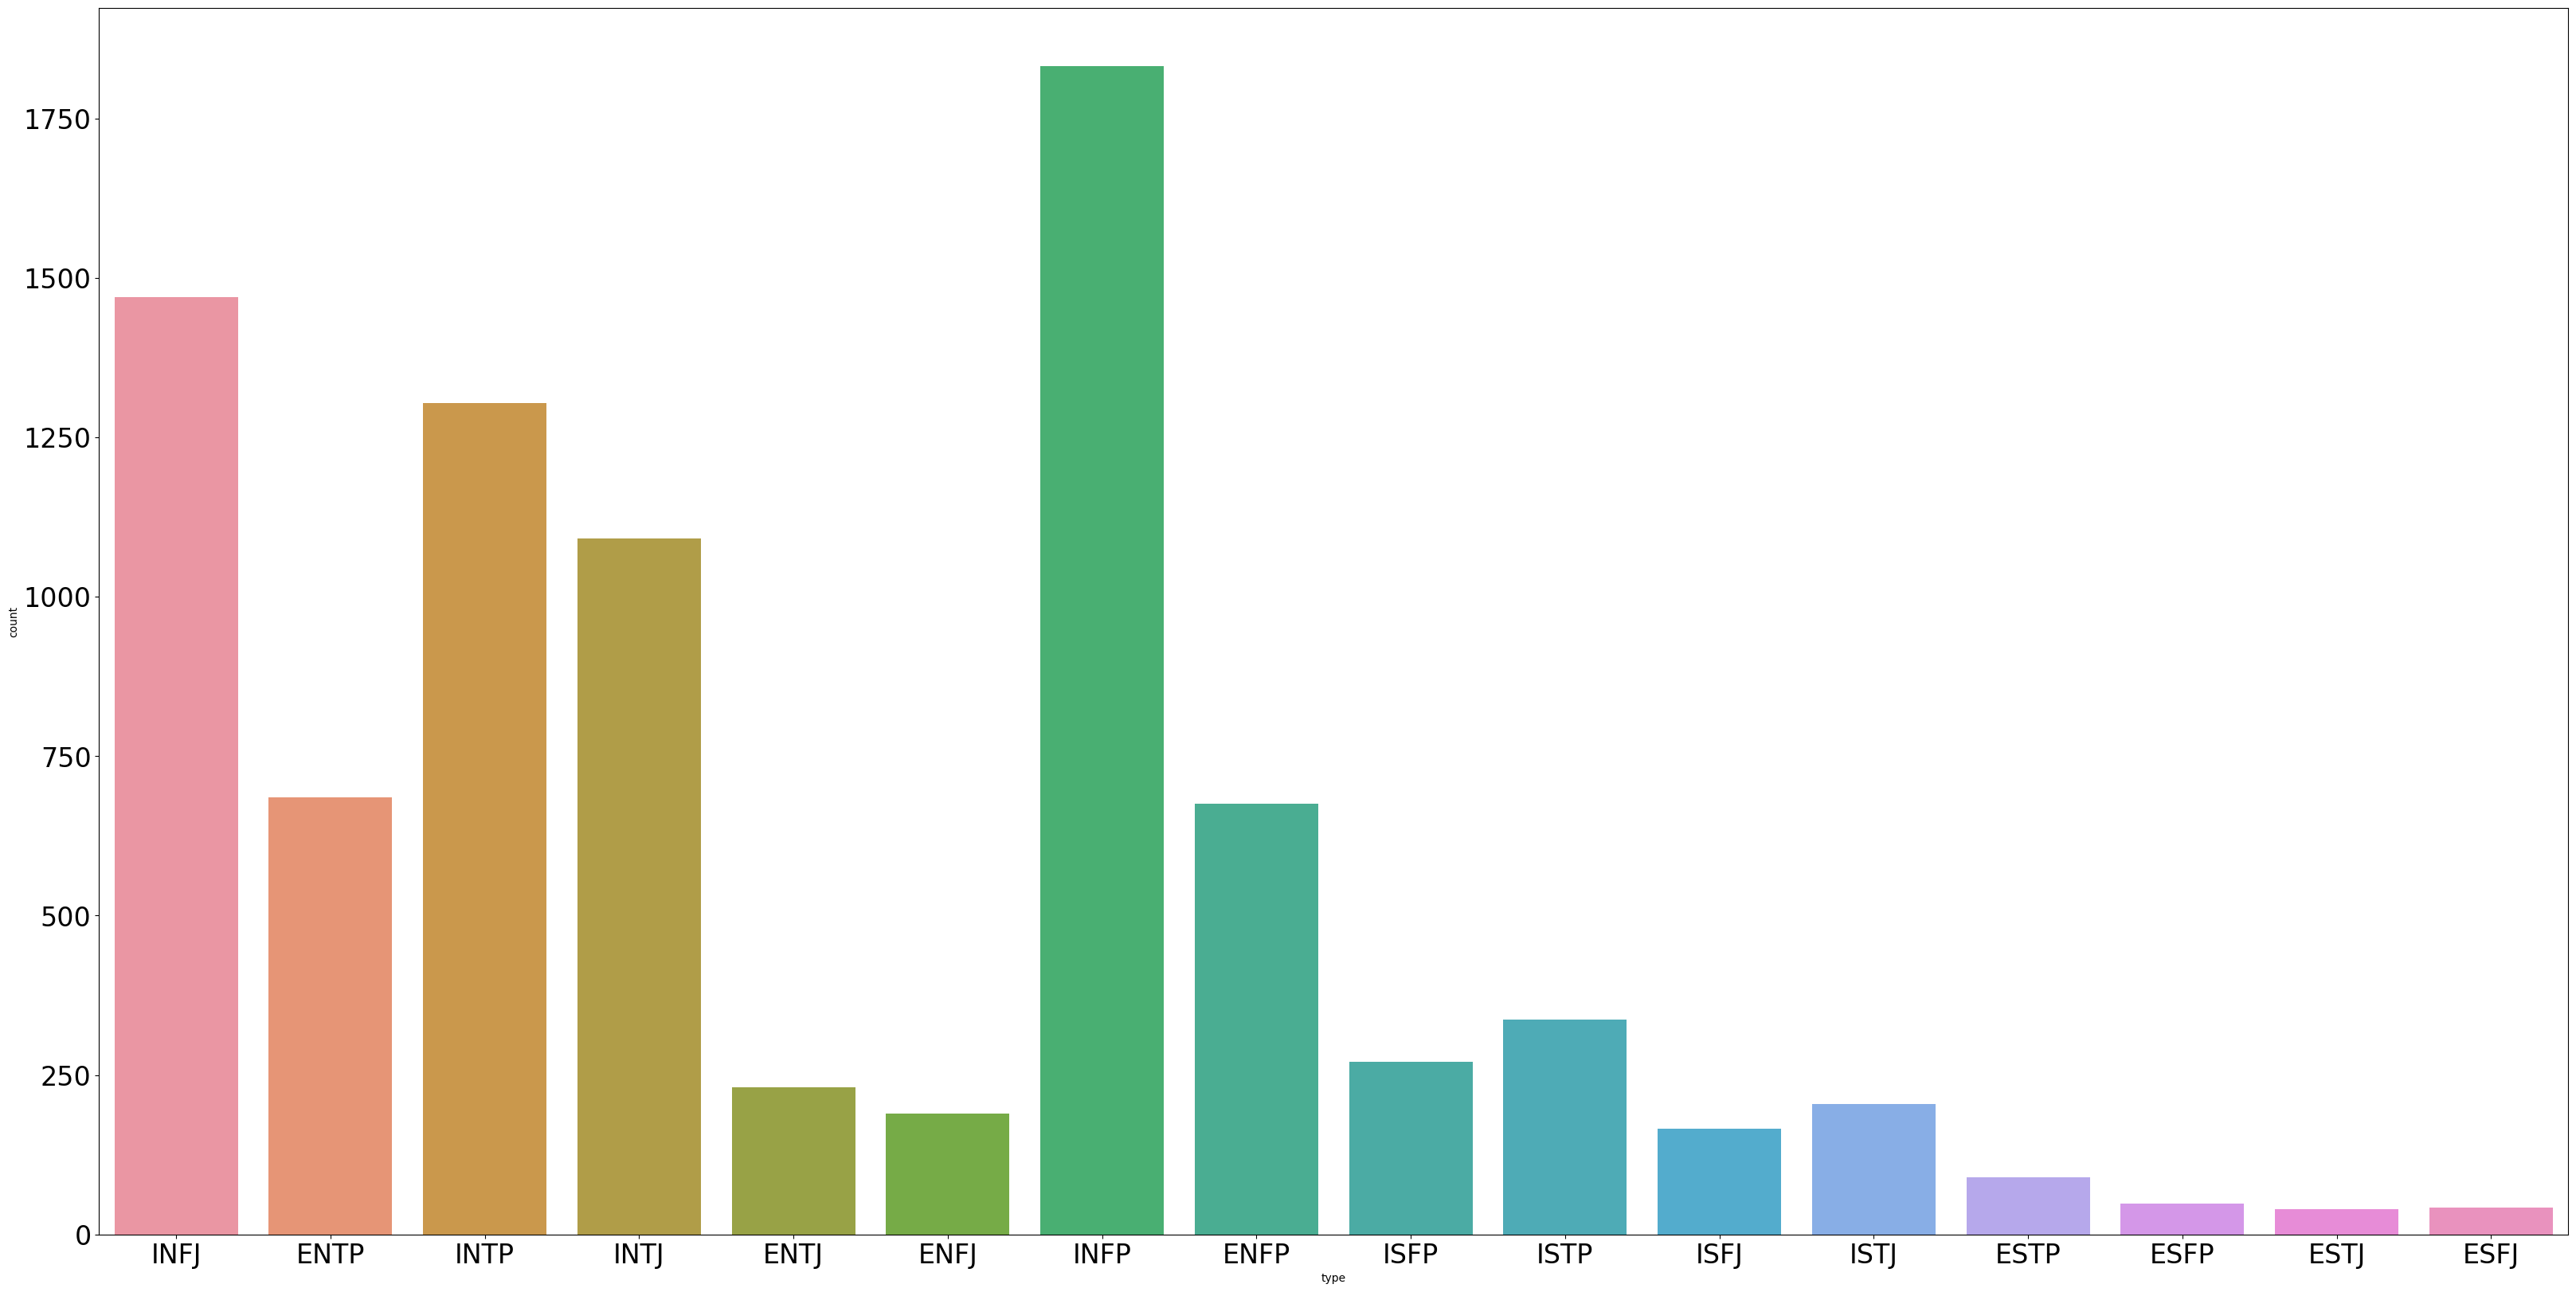

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(40,20))
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=data, x='type')

In [5]:
import re

In [6]:
def preprocess_text(df):
    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crucial in order to get valid model accuracy estimation for unseen data. 
    pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
    pers_types = [p.lower() for p in pers_types]
    p = re.compile("(" + "|".join(pers_types) + ")")
    df["posts"] = df["posts"].apply(lambda x: re.sub(p,'',x))
    
    return df

In [7]:
new_df = preprocess_text(data)
new_df

,type,posts
0,INFJ,moments sportscenter plays prank...
1,ENTP,finding lack these posts very alarming eo...
2,INTP,good course which know thats bles...
3,INTJ,dear enjoyed conversation other eostoke...
4,ENTJ,youre fired eostokendot thats another silly...
...,...,...
8670,ISFP,ixfp just because always think cats doms...
8671,ENFP,eostokendot eostokendot eostokendot this t...
8672,INTP,many questions when these things eostokendo...
8673,INFP,very conflicted right when comes wanting ...


In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(new_df,test_size=0.2,random_state=42,stratify=new_df.type)

## 단어 토큰화

In [10]:
!pip install mylib

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer( max_features=5000,stop_words='english')
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english')

In [14]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [15]:
train_post.shape

(6940, 5000)

In [17]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
train_target = target_encoder.fit_transform(train_data.type)
test_target = target_encoder.fit_transform(test_data.type)

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_post,train_target)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [23]:
from sklearn.metrics import classification_report

print('Train classification result \n ',classification_report(train_target,model.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

Train classification result 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       152
        ENFP       0.57      0.15      0.24       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.84      0.08      0.15       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.51      0.57      0.54      1176
        INFP       0.39      0.89      0.55      1466
        INTJ       0.69      0.47      0.56       873
        INTP       0.48      0.70      0.57      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       0.00      0.00      0.00       270

    accuracy                           0.47      

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))